In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
from pypfopt import EfficientSemivariance, EfficientCVaR, EfficientCDaR, HRPOpt, EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from riskfolio import RiskFunctions
from collections import OrderedDict


sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (14, 10) # não sei o motivo, mas o use acima reseta o size.

In [2]:
ANO = 2019

In [25]:
dados_acoes = pd.read_csv("dados_acoes.csv").set_index("Date")
dados_acoes = dados_acoes[f"{ANO}-01-01":].fillna(method="ffill")
dados_acoes.head()

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BOVA11,BRML3,CCRO3,CIEL3,...,KLBN11,LREN3,MGLU3,MULT3,PETR4,PRIO3,RADL3,UGPA3,USIM5,VALE3
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,14.685471,8.211551,40.703751,21.585308,26.543947,22.948406,87.900002,12.521656,10.834820,8.264735,...,15.233185,37.322678,5.641579,23.437693,18.925686,2.0712,11.081697,26.082016,8.779833,40.610806
2019-01-03,14.849148,8.569091,40.871254,22.036453,26.811701,23.199608,88.000000,12.605382,11.186951,8.067341,...,15.625457,36.851326,5.581216,23.606987,19.389780,2.0758,11.056290,25.597237,8.590923,38.949490
2019-01-04,15.049197,8.258827,40.871254,21.553459,26.601313,22.972717,88.500000,12.363507,11.060544,8.711014,...,15.877631,35.437256,5.411353,23.127321,19.444843,2.0932,11.214598,25.424446,9.094683,41.485180
2019-01-07,14.985545,8.214504,40.603252,21.734575,26.916899,22.632381,88.480003,12.289084,10.744529,8.633773,...,15.877631,34.623108,5.495374,22.798141,19.751619,2.0914,10.964430,24.646879,9.112675,41.262611
2019-01-08,14.685471,8.238147,40.142609,21.976074,27.081263,22.300148,88.830002,12.307690,11.051516,8.341974,...,15.943008,35.737221,5.451089,22.638254,19.633627,2.1414,11.365091,24.238899,8.858072,41.660057


In [26]:
dados_cripto = pd.read_csv("dados_criptos.csv").set_index("Date")
dados_cripto = dados_cripto[f"{ANO}-01-01":].fillna(method="bfill")
dados_cripto.head()

,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DCR-USD,DOGE-USD,EOS-USD,ETC-USD,ETH-USD,FIL-USD,...,NEO-USD,REP-USD,THETA-USD,TRX-USD,VET-USD,WAVES-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.042547,164.854599,6.075273,3843.520020,17.464001,0.002392,2.663533,5.227261,140.819412,3.016652,...,7.866171,8.195203,0.049690,0.019561,0.004145,3.162524,0.115930,48.367496,0.364771,0.474699
2019-01-02,0.045258,171.827377,6.188613,3943.409424,18.415791,0.002407,2.887629,5.438700,155.047684,3.344247,...,8.076462,8.868501,0.050489,0.020222,0.004231,3.153164,0.119331,52.252449,0.375243,0.485319
2019-01-03,0.042682,162.049927,5.903535,3836.741211,18.236917,0.002360,2.681411,5.094617,149.135010,3.337603,...,7.679240,8.638993,0.052906,0.020088,0.004051,3.103900,0.113825,49.815357,0.360224,0.482134
2019-01-04,0.043812,161.395630,6.065138,3857.717529,18.562626,0.002315,2.721645,5.254148,154.581940,3.461010,...,7.634589,9.245858,0.051363,0.021492,0.004094,3.086819,0.115361,50.630875,0.356747,0.483029
2019-01-05,0.044701,160.401215,6.065543,3845.194580,18.490410,0.002319,2.699468,5.136273,155.638596,3.208686,...,7.844755,9.298466,0.050197,0.022294,0.004074,3.073536,0.114046,49.931812,0.355275,0.483224


In [27]:
dados = dados_acoes.join(dados_cripto)
dados.head()

,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BOVA11,BRML3,CCRO3,CIEL3,...,NEO-USD,REP-USD,THETA-USD,TRX-USD,VET-USD,WAVES-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,14.685471,8.211551,40.703751,21.585308,26.543947,22.948406,87.900002,12.521656,10.834820,8.264735,...,8.076462,8.868501,0.050489,0.020222,0.004231,3.153164,0.119331,52.252449,0.375243,0.485319
2019-01-03,14.849148,8.569091,40.871254,22.036453,26.811701,23.199608,88.000000,12.605382,11.186951,8.067341,...,7.679240,8.638993,0.052906,0.020088,0.004051,3.103900,0.113825,49.815357,0.360224,0.482134
2019-01-04,15.049197,8.258827,40.871254,21.553459,26.601313,22.972717,88.500000,12.363507,11.060544,8.711014,...,7.634589,9.245858,0.051363,0.021492,0.004094,3.086819,0.115361,50.630875,0.356747,0.483029
2019-01-07,14.985545,8.214504,40.603252,21.734575,26.916899,22.632381,88.480003,12.289084,10.744529,8.633773,...,8.471042,9.395186,0.051540,0.023601,0.004176,2.951987,0.123220,52.826897,0.364347,0.481431
2019-01-08,14.685471,8.238147,40.142609,21.976074,27.081263,22.300148,88.830002,12.307690,11.051516,8.341974,...,9.175762,10.048374,0.050526,0.026336,0.004382,2.887409,0.123119,53.155445,0.365315,0.484993


In [28]:
def gera_portfolio(dados_precos, tipo_dado, tipo='semivariancia', mostra_performance=False):
  in_sample, out_sample = dados_precos[:"2021-01-01"], dados_precos["2021-01-01":]

  mu = expected_returns.mean_historical_return(in_sample)
  historical_returns = expected_returns.returns_from_prices(in_sample)

  if tipo == 'semivariancia':
    es = EfficientSemivariance(mu, historical_returns)
    raw_weights = es.min_semivariance()
  elif tipo =='cvar':
    es = EfficientCVaR(mu, historical_returns)
    raw_weights = es.min_cvar()
  elif tipo == 'cdar':
    es = EfficientCDaR(mu, historical_returns)
    raw_weights = es.min_cdar()
  elif tipo =='hrp':
    es = HRPOpt(historical_returns)
    es.optimize()
    raw_weights = es.clean_weights()
  elif tipo == 'markowitz':
    S = risk_models.sample_cov(in_sample)
    es = EfficientFrontier(mu, S)
    raw_weights = es.min_volatility()
  else:
    raise ValueError("Tipo de portfólio não encotrado!")

  formatted_weights = np.asarray([weight for weight in raw_weights.values()])
  if mostra_performance:
    print(f"{tipo.capitalize()} - {tipo_dado} - Expected performance:")
    es.portfolio_performance(verbose=True)
    print()
  return raw_weights, formatted_weights, out_sample

In [29]:
def portfolio_metrics(price_data, tipo='semivariancia', rf=0.1075, frequency=252):
  mu = expected_returns.mean_historical_return(price_data.to_frame()).iloc[0]
  returns = price_data.pct_change().dropna()
  actual_return = (price_data.iloc[-1]-price_data.iloc[0])/price_data.iloc[0]
  
  print(f"Actual return: {actual_return:.2%}")
  print(f"Expected annual return: {mu:.2%}")

  if tipo == 'semivariancia':
    drops = np.fmin(returns, 0)
    semivariance = np.sum(np.square(drops)) / returns.shape[0] * frequency
    semi_deviation = np.sqrt(semivariance)
    sortino_ratio = (mu - rf) / semi_deviation

    print("Annual semi-deviation: {:.1f}%".format(100 * semi_deviation))
    print("Sortino Ratio: {:.2f}".format(sortino_ratio))

  elif tipo == 'cvar':
    alpha = 0.95
    var = np.percentile(returns, 100 * (1-alpha))
    cvar_val = np.mean(returns[returns < var])

    print("Conditional Value at Risk: {:.2f}%".format(100 * cvar_val))
  
  elif tipo == 'cdar':
    cdar_val = RiskFunctions.CDaR_Rel(returns)
    print("Conditional Drawdown at Risk: {:.2f}%".format(100 * cdar_val))

  elif tipo == 'hrp' or tipo == 'markowitz':
    sd_p = math.sqrt(risk_models.sample_cov(price_data.to_frame()).iloc[0][0])
    
    print(f"Annual volatility: {sd_p:.2%}")
    print(f"Sharpe ratio: {(mu-rf)/sd_p:.2f}")
    
  else:
    raise ValueError("Tipo de portfólio não encotrado!")

In [30]:
def backtest(tipo_port: str, tipo_dado: str):
  if tipo_dado == 'crypto':
    data = dados
  elif tipo_dado == 'no_crypto':
    data = dados_acoes
  else:
    raise ValueError("Tipo de dado não encontrado!")

  C = 10_000
  raw_weights, portfolio_weights, out_sample = gera_portfolio(data, tipo_dado, tipo_port, True)
  backtest_range = out_sample.index
  out_sample_returns = out_sample.pct_change().dropna()

  if "BTC-USD" in out_sample_returns.columns and len(portfolio_weights) != 25:
    stock_proportion = 1 - portfolio_weights[-25:].sum()
    equal_stocks = np.repeat(stock_proportion/len(dados_acoes.columns), len(dados_acoes.columns))
    equal_crypto = np.repeat((1 - stock_proportion)/len(dados_cripto.columns), len(dados_cripto.columns))
    equal_weights = np.concatenate((equal_stocks, equal_crypto))
  else:
    equal_weights = np.ones_like(out_sample.columns) / len(out_sample.columns)

  capital = [(C, C)]

  for _, row in out_sample_returns.iterrows():
    portofolio_return, equal_return = np.dot(portfolio_weights, row), np.dot(equal_weights, row)

    C_portfolio, C_equal = capital[-1][0] * (1+portofolio_return), capital[-1][1] * (1+equal_return)
    capital.append((C_portfolio, C_equal))
  

  backtest_df = pd.DataFrame(capital, index=backtest_range, columns=["Portfolio", "Equally Weighted"])

  print("Backtest performance:")
  portfolio_metrics(backtest_df['Portfolio'], tipo_port)
  print()
  print("Equally Weighted:")
  portfolio_metrics(backtest_df['Equally Weighted'], tipo_port)
  print()


  backtest_df.plot()
  plt.title(f"Portfolio Value Over Time - {tipo_port.capitalize()} - {tipo_dado}")
  plt.tight_layout()
  plt.savefig(f"graficos2/port_value_{tipo_port}_{tipo_dado}.png")

  return raw_weights

Semivariancia - crypto - Expected performance:
Expected annual return: 32.7%
Annual semi-deviation: 18.1%
Sortino Ratio: 1.70

Backtest performance:
Actual return: -2.48%
Expected annual return: -2.54%
Annual semi-deviation: 13.2%
Sortino Ratio: -1.00

Equally Weighted:
Actual return: -9.06%
Expected annual return: -9.27%
Annual semi-deviation: 17.1%
Sortino Ratio: -1.17

Semivariancia - no_crypto - Expected performance:
Expected annual return: 30.6%
Annual semi-deviation: 18.3%
Sortino Ratio: 1.57

Backtest performance:
Actual return: -8.43%
Expected annual return: -8.63%
Annual semi-deviation: 13.5%
Sortino Ratio: -1.43

Equally Weighted:
Actual return: -13.66%
Expected annual return: -13.96%
Annual semi-deviation: 17.1%
Sortino Ratio: -1.45

Cvar - crypto - Expected performance:
Expected annual return: 42.4%
Conditional Value at Risk: 3.58%

Backtest performance:
Actual return: 17.53%
Expected annual return: 18.00%
Conditional Value at Risk: -2.73%

Equally Weighted:
Actual return: 

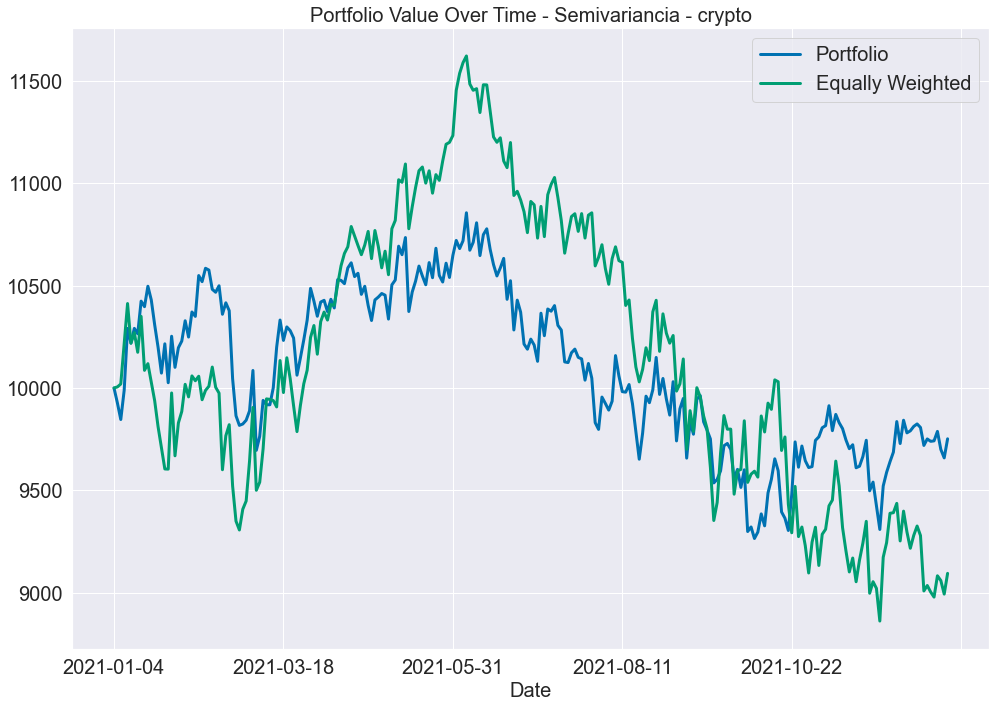

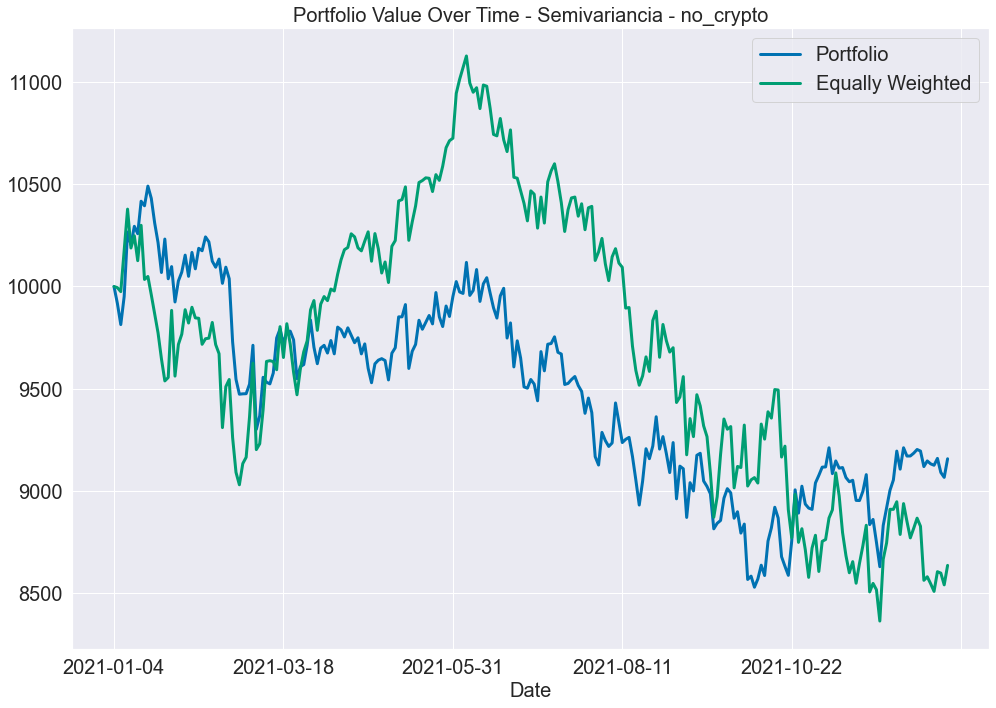

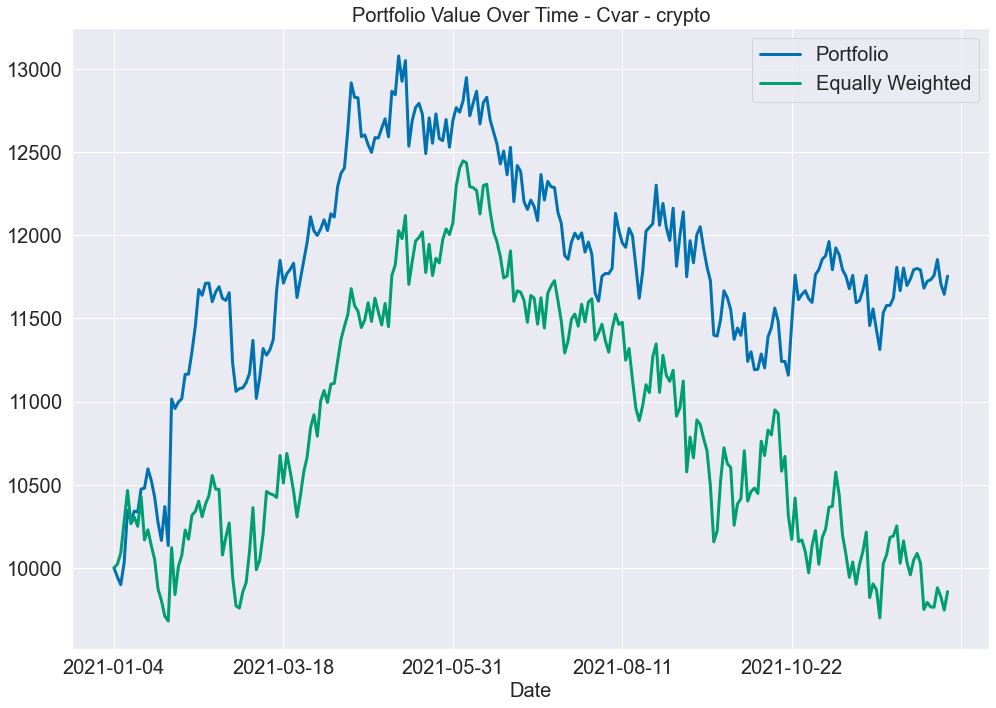

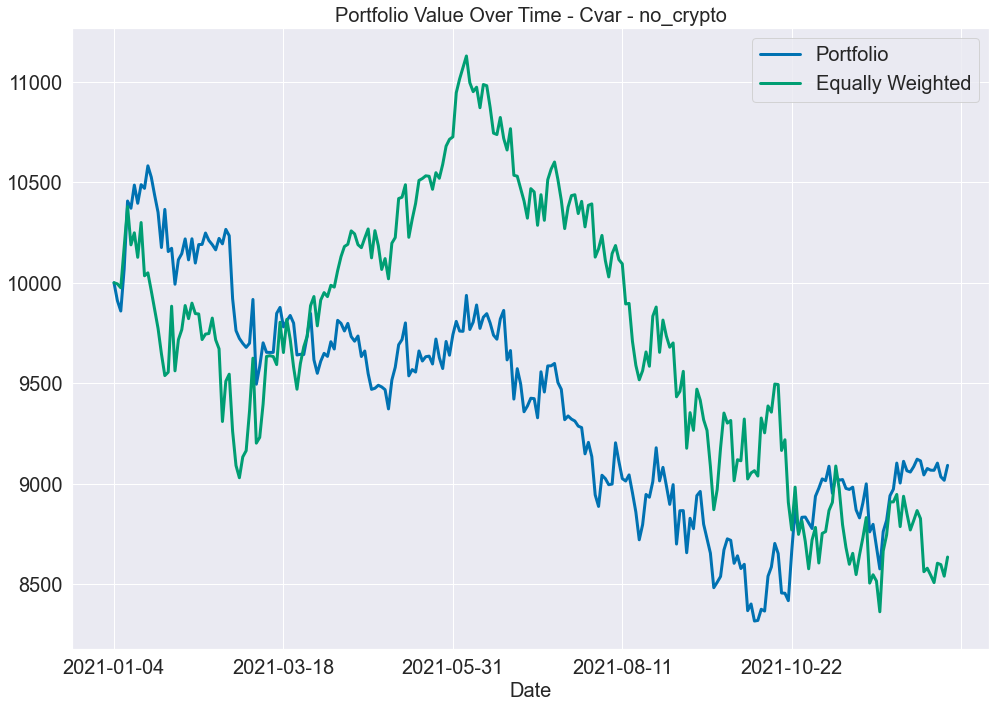

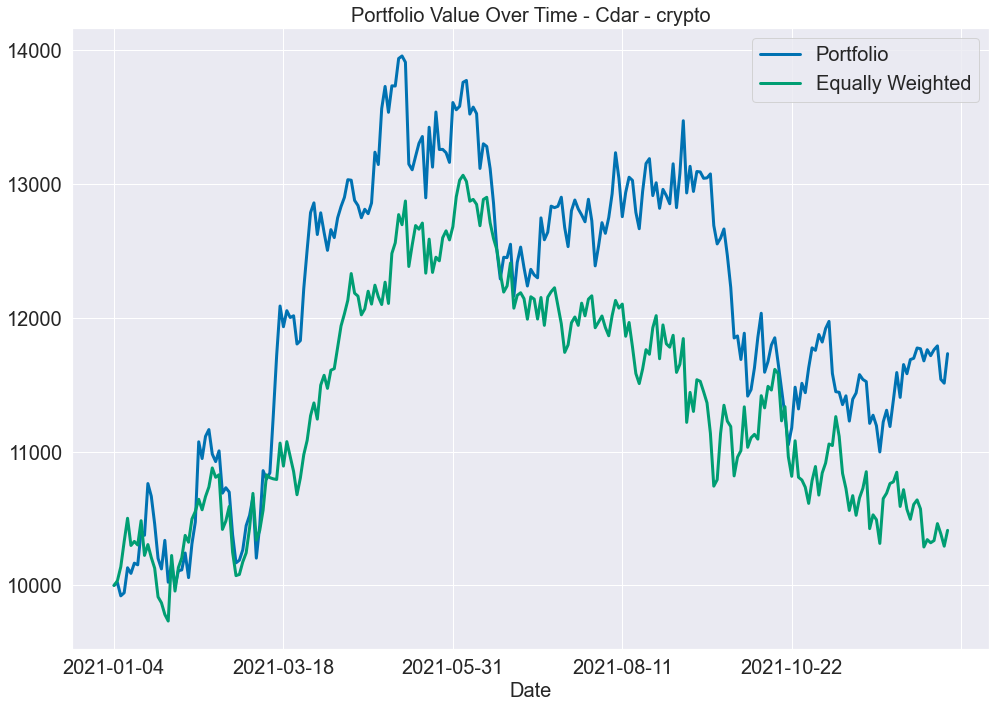

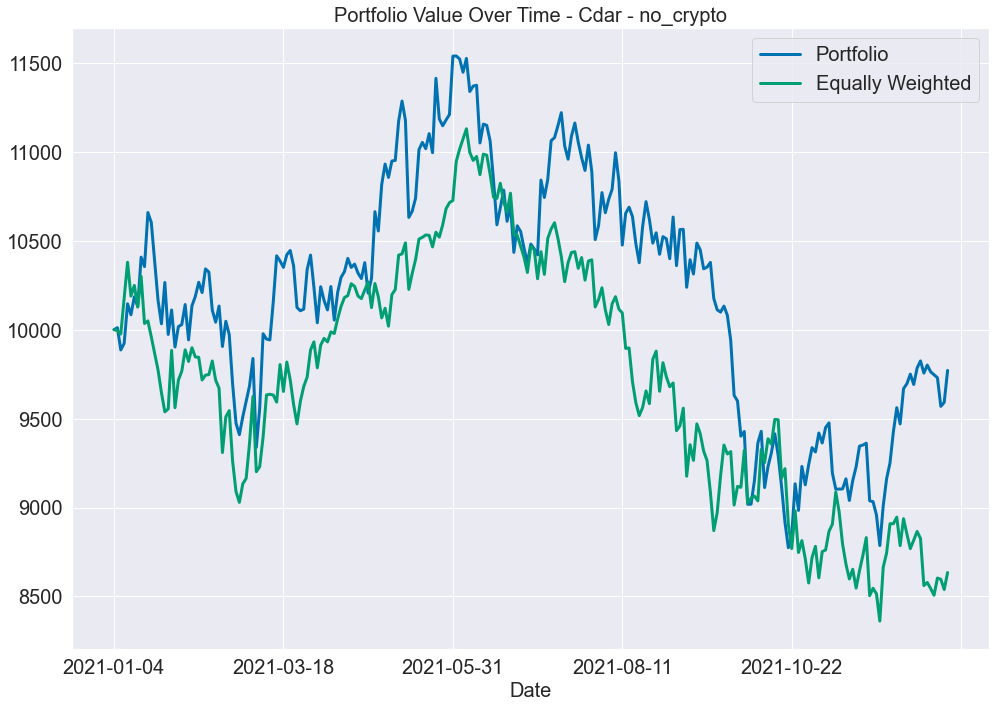

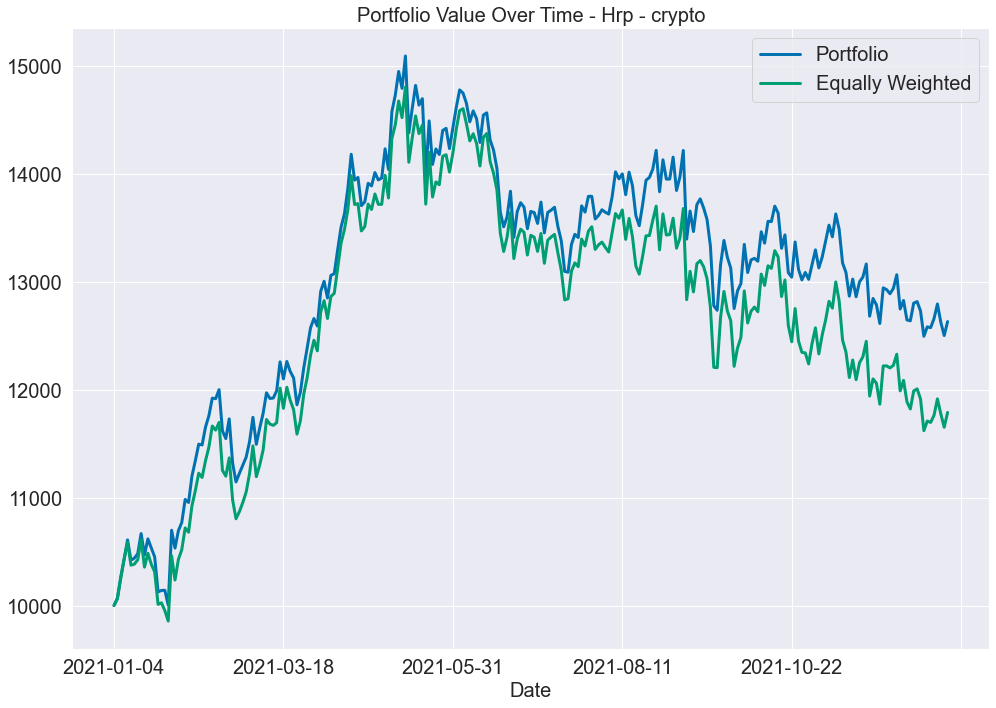

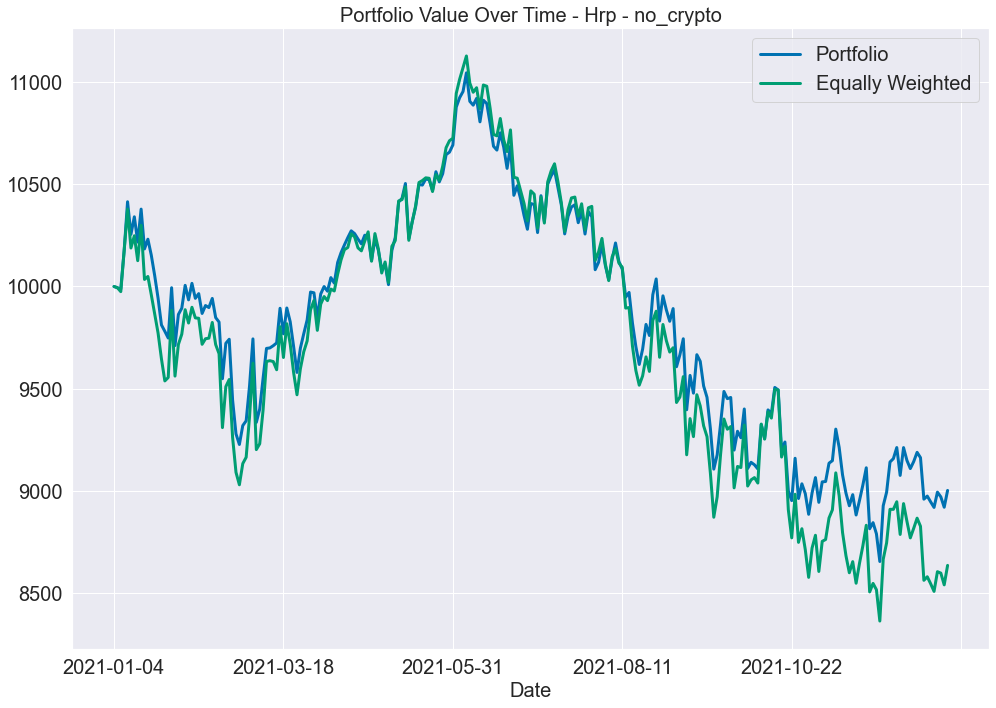

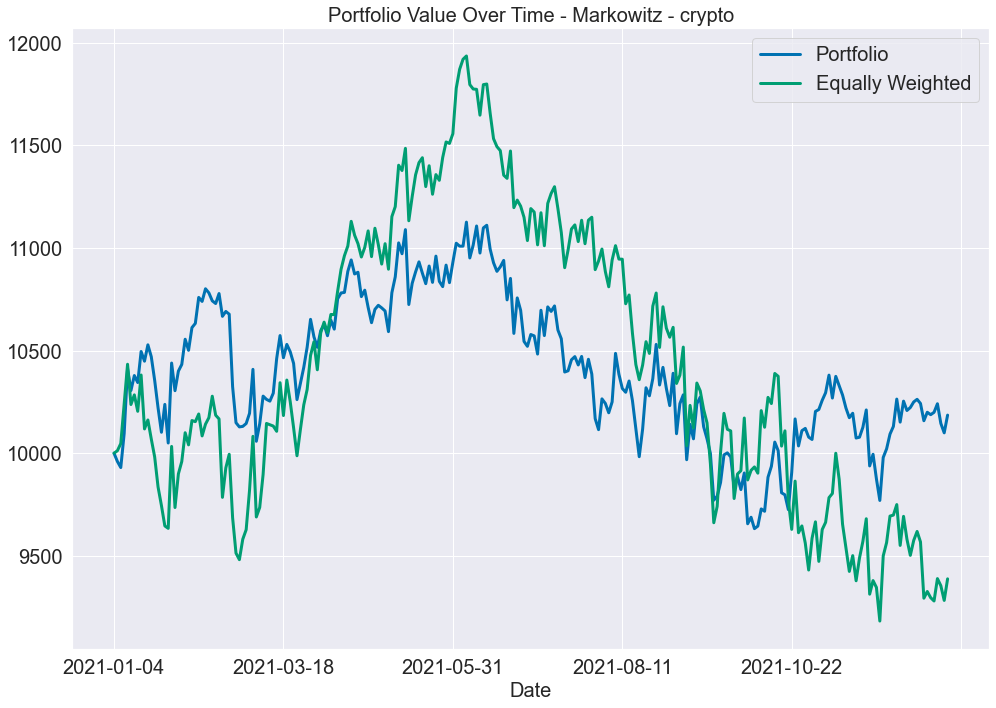

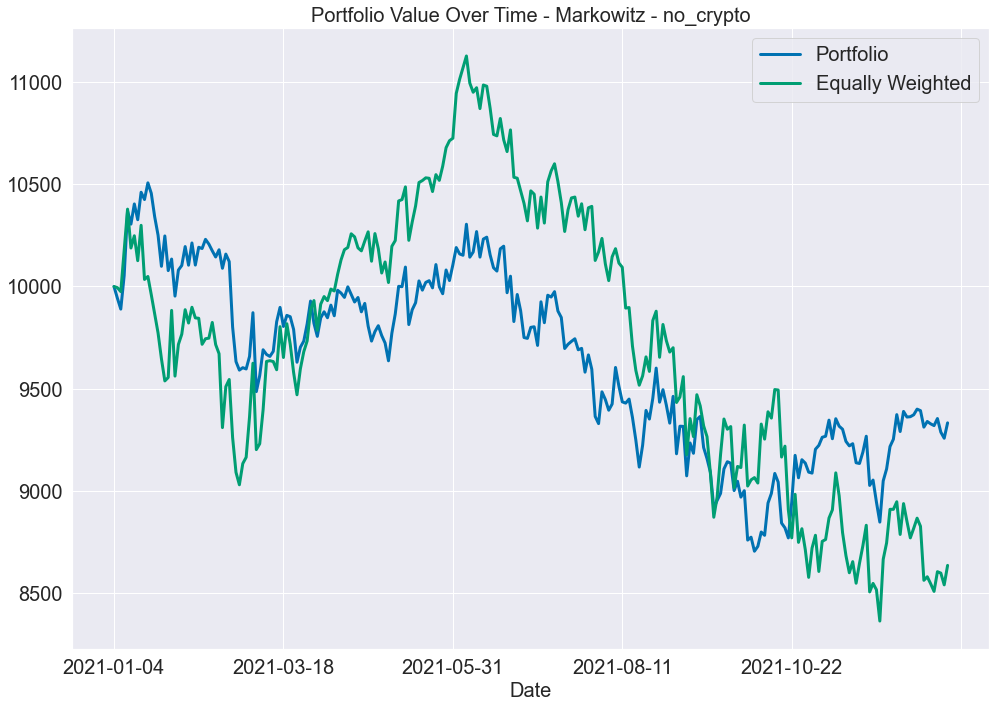

In [31]:
tipos_port = ['semivariancia', 'cvar', 'cdar', 'hrp', 'markowitz']
tipos_dados = ['crypto', 'no_crypto']
pesos = []

for tipo_port in tipos_port:
    for tipo_dados in tipos_dados:
        peso = backtest(tipo_port, tipo_dados)
        pesos.append({"tipo_port": tipo_port, "tipo_dado": tipo_dados, "pesos": peso})

In [32]:
print(len(pesos))

10


In [33]:
def print_weights(raw_weights, tipo_port, tipo_dado):
    new_weights = OrderedDict()
    for ticker in raw_weights:
        if raw_weights[ticker] > 0.01:
            new_weights[ticker] = raw_weights[ticker]

    ax = pd.Series(new_weights).plot.barh()
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.title(f"Portfolio Composition - {tipo_port.capitalize()} - {tipo_dado}")
    plt.xlabel("Proportion")
    plt.tight_layout()
    plt.savefig(f"graficos2/port_composition_{tipo_port}_{tipo_dado}.png")

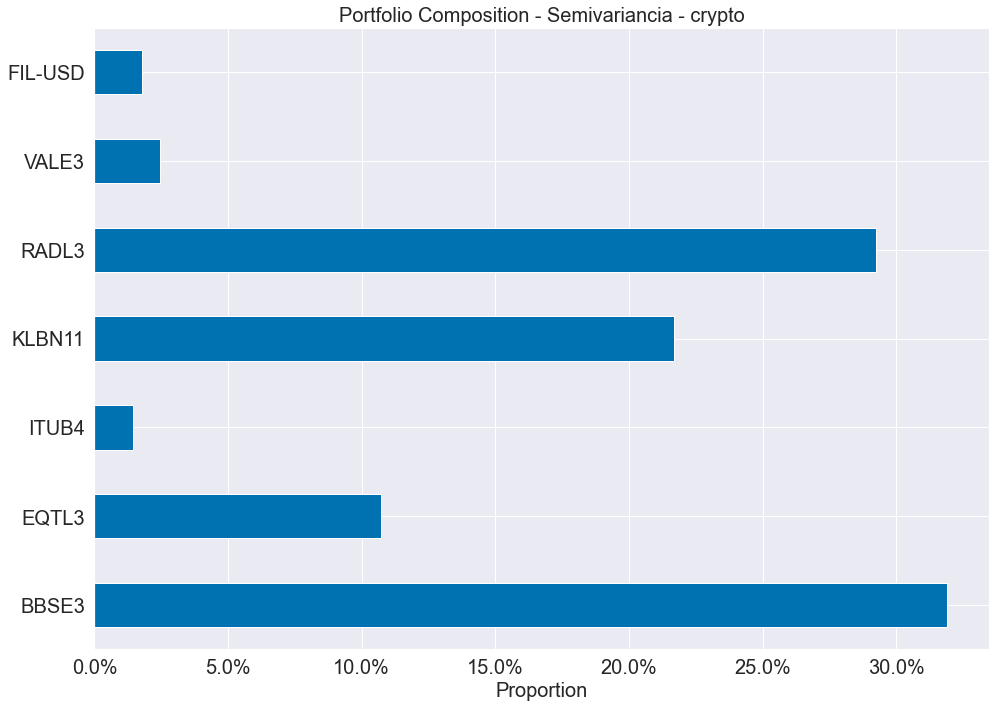

In [34]:
print_weights(pesos[0]['pesos'], pesos[0]['tipo_port'], pesos[0]['tipo_dado'])

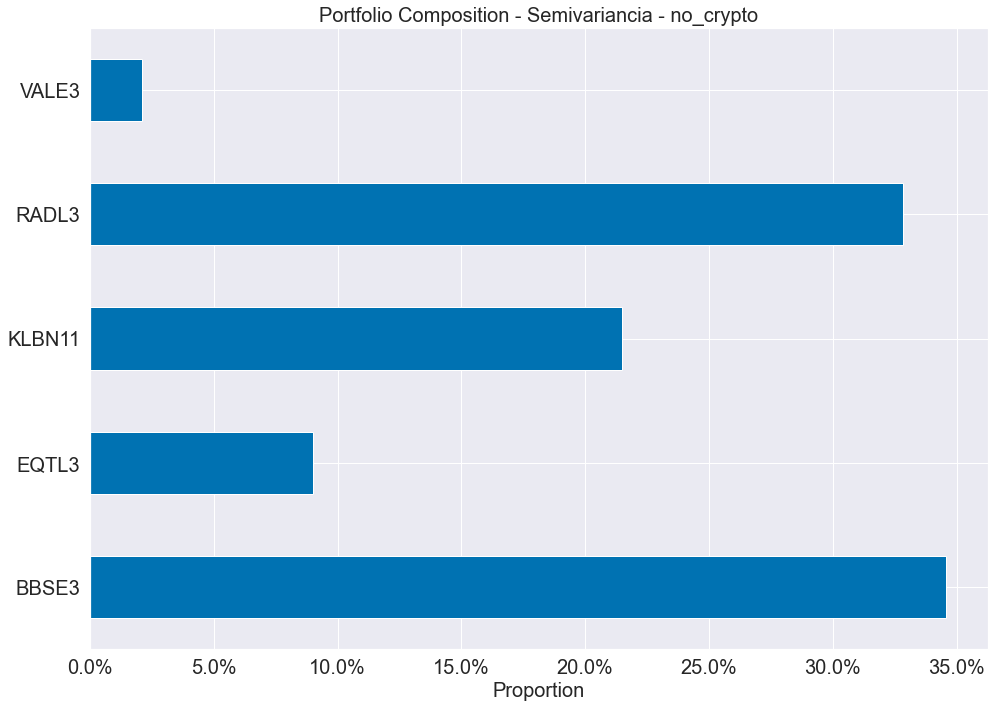

In [35]:
print_weights(pesos[1]['pesos'], pesos[1]['tipo_port'], pesos[1]['tipo_dado'])

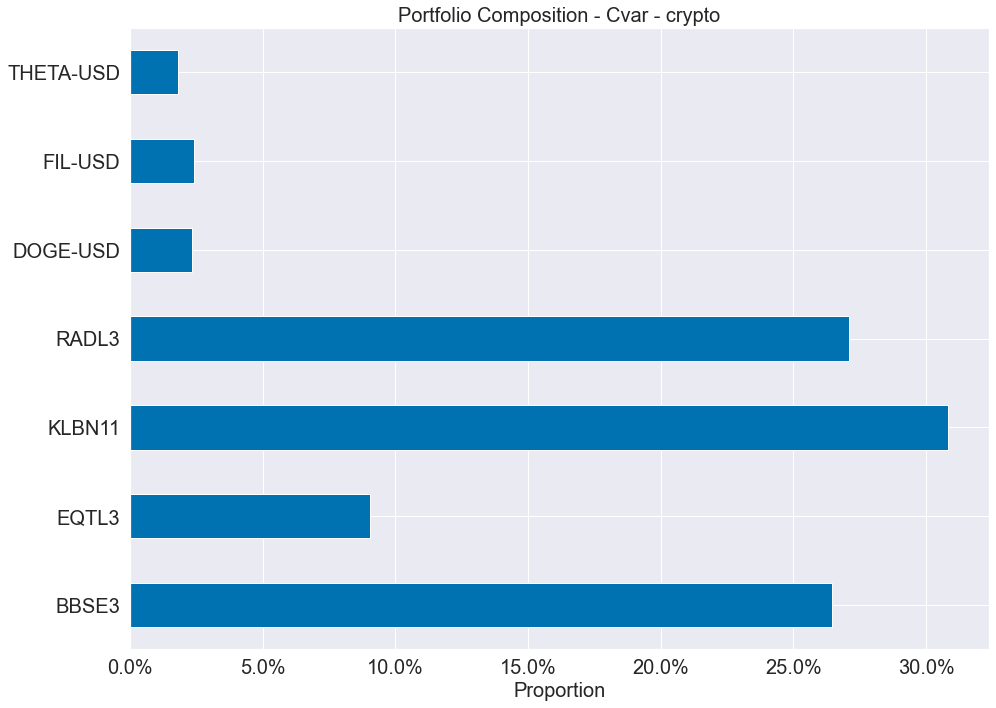

In [36]:
print_weights(pesos[2]['pesos'], pesos[2]['tipo_port'], pesos[2]['tipo_dado'])

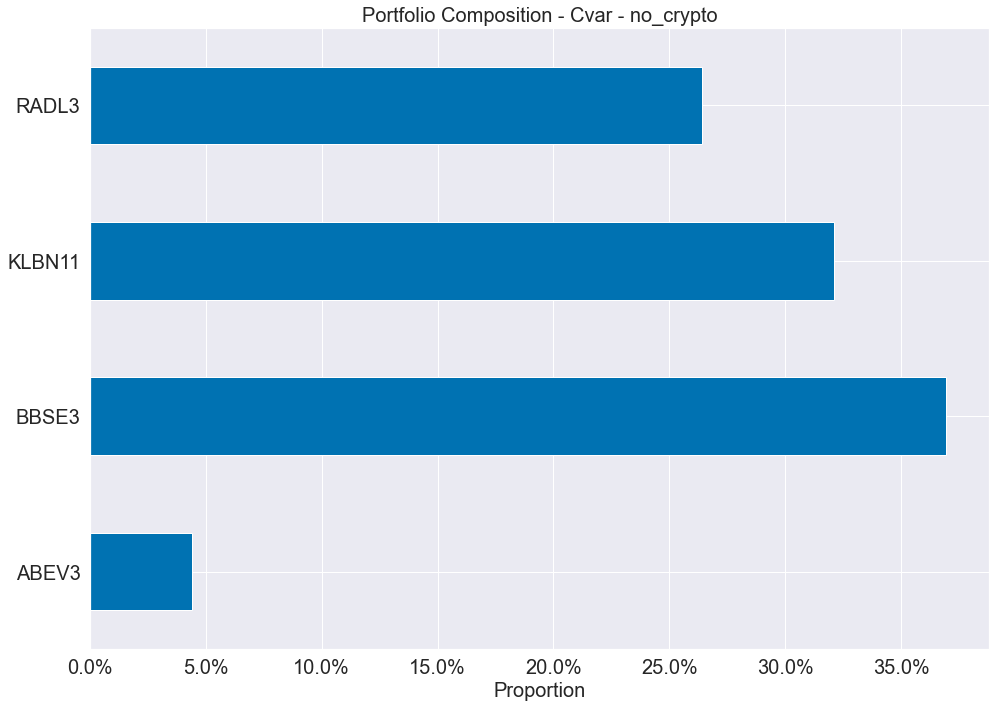

In [37]:
print_weights(pesos[3]['pesos'], pesos[3]['tipo_port'], pesos[3]['tipo_dado'])

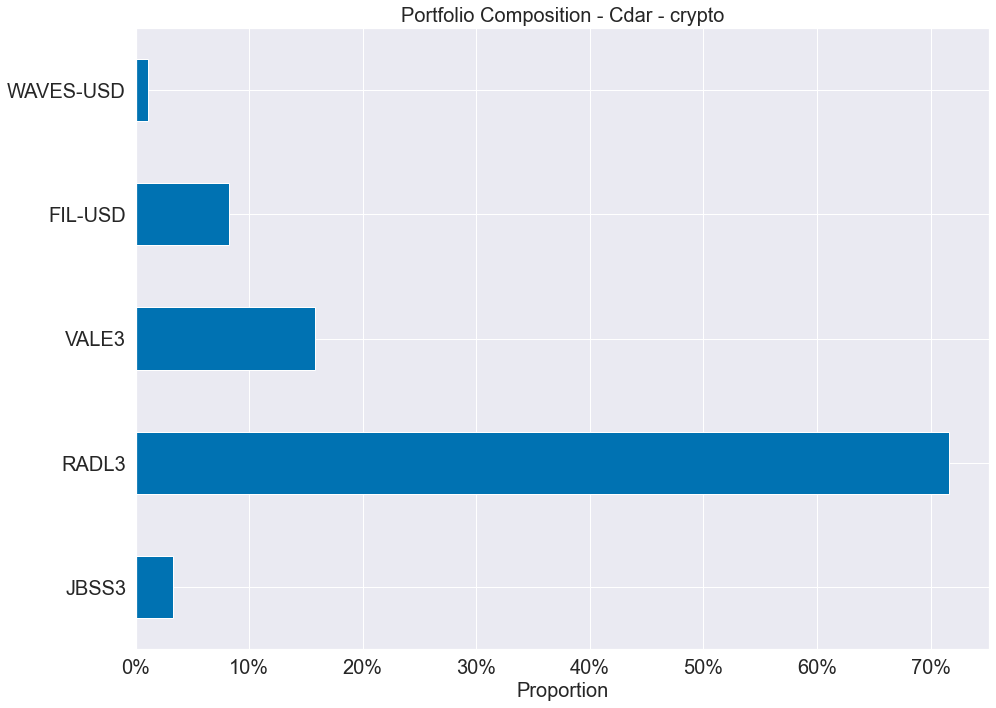

In [38]:
print_weights(pesos[4]['pesos'], pesos[4]['tipo_port'], pesos[4]['tipo_dado'])

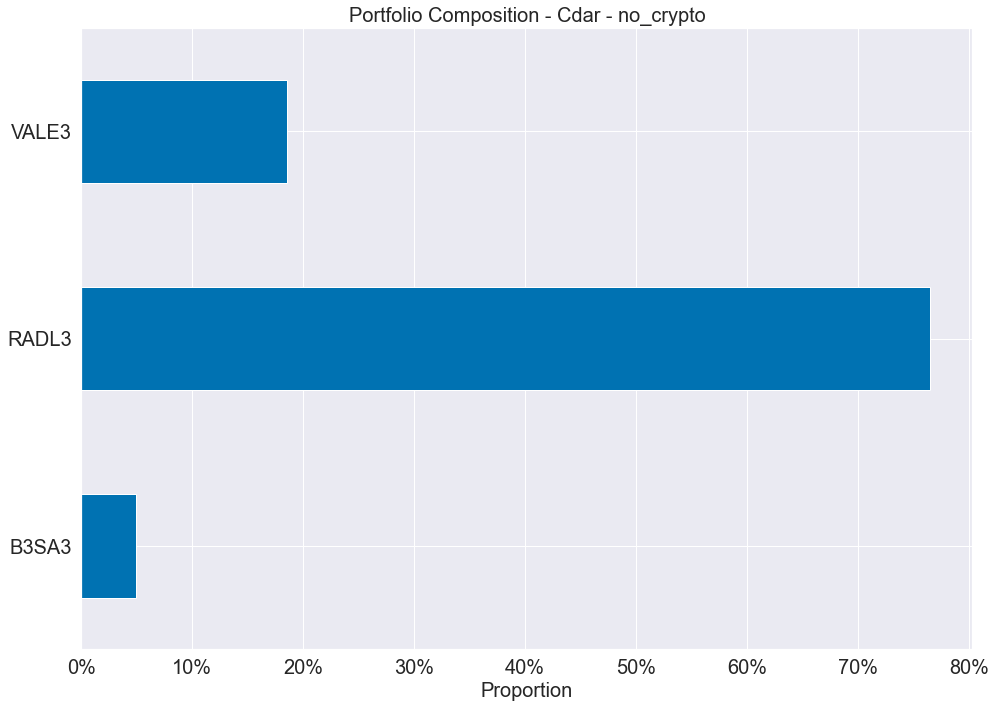

In [39]:
print_weights(pesos[5]['pesos'], pesos[5]['tipo_port'], pesos[5]['tipo_dado'])

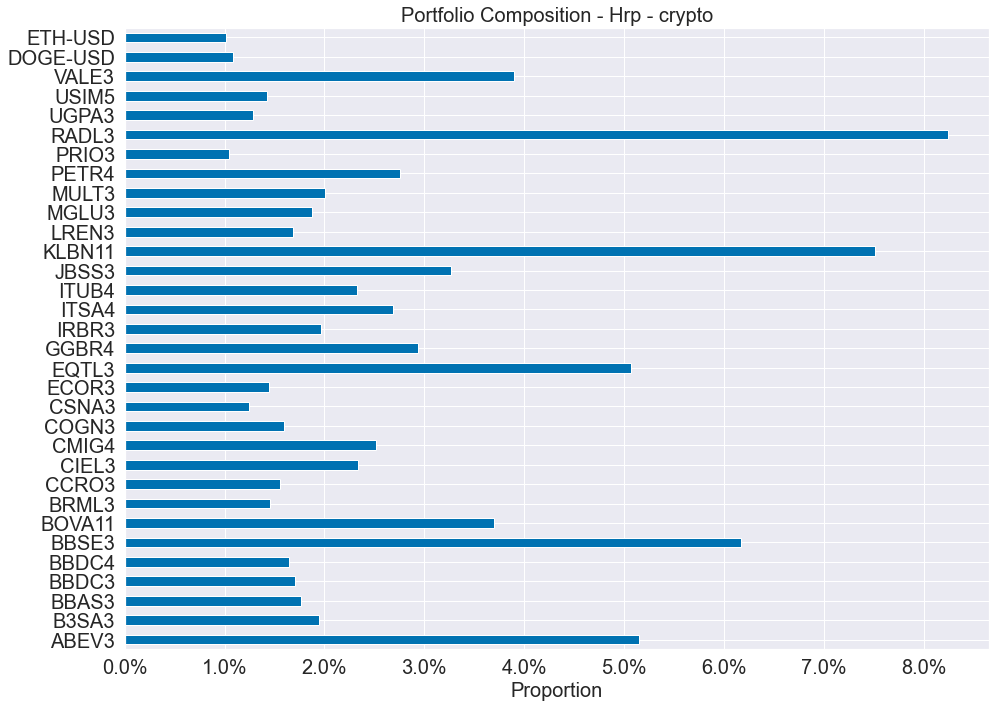

In [40]:
print_weights(pesos[6]['pesos'], pesos[6]['tipo_port'], pesos[6]['tipo_dado'])

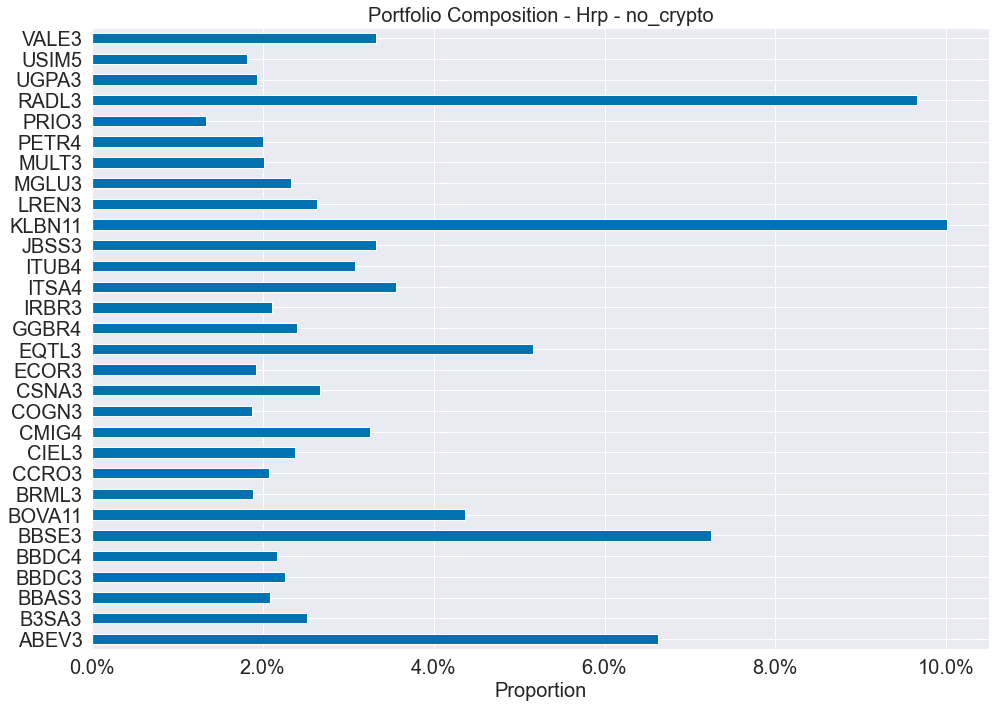

In [41]:
print_weights(pesos[7]['pesos'], pesos[7]['tipo_port'], pesos[7]['tipo_dado'])

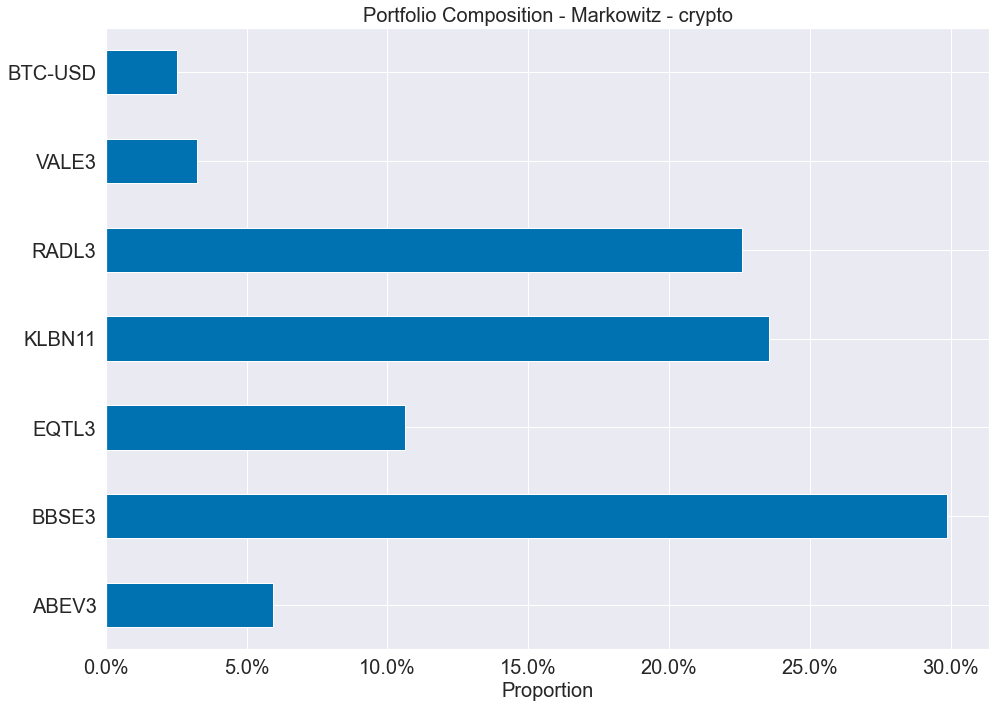

In [42]:
print_weights(pesos[8]['pesos'], pesos[8]['tipo_port'], pesos[8]['tipo_dado'])

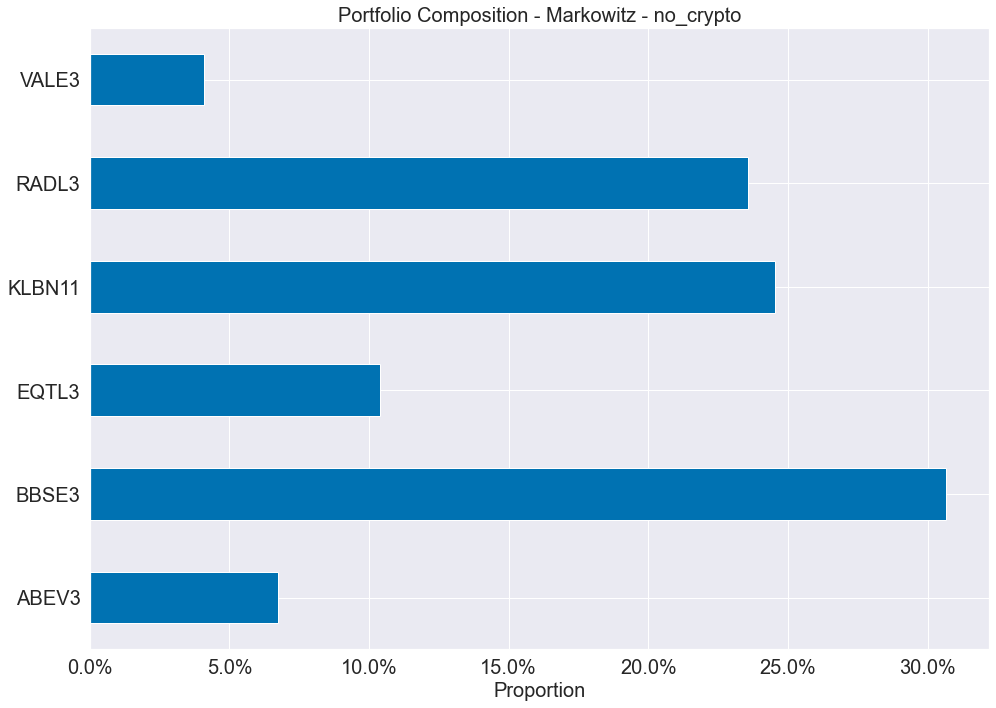

In [43]:
print_weights(pesos[9]['pesos'], pesos[9]['tipo_port'], pesos[9]['tipo_dado'])

In [44]:
def compare_portfolios(tipo_port: str):
  C = 10_000

  _, portfolio_com_cripto, out_sample_cripto = gera_portfolio(dados, "crypto", tipo_port)

  _, portfolio_sem_cripto, out_sample_sem_cripto = gera_portfolio(dados_acoes, "no_crypto", tipo_port)

  backtest_range = out_sample_cripto.index

  out_sample_cripto_returns = out_sample_cripto.pct_change().dropna()
  out_sample_sem_cripto_returns = out_sample_sem_cripto.pct_change().dropna()

  capital = [(C, C)]

  for date in out_sample_cripto_returns.index:
    cripto_row, no_cripto_row = out_sample_cripto_returns.loc[date], out_sample_sem_cripto_returns.loc[date]

    cripto_return, no_cripto_return = np.dot(portfolio_com_cripto, cripto_row), np.dot(portfolio_sem_cripto, no_cripto_row)

    C_cripto, C_no_cripto = capital[-1][0] * (1+cripto_return), capital[-1][1] * (1+no_cripto_return)
    capital.append((C_cripto, C_no_cripto))

  backtest_df = pd.DataFrame(capital, index=backtest_range, columns=["Crypto", "No-Crypto"])

  print(f"Backtest performance - {tipo_port} - Crypto:")
  portfolio_metrics(backtest_df['Crypto'], tipo_port)
  print()
  print(f"Backtest performance - {tipo_port} - No Crypto:")
  portfolio_metrics(backtest_df['No-Crypto'], tipo_port)
  print()


  backtest_df.plot()
  plt.title(f"Portfolio Comparison - {tipo_port.capitalize()}")
  plt.tight_layout()
  plt.savefig(f"graficos2/port_comp_{tipo_port}.png")

Backtest performance - semivariancia - Crypto:
Actual return: -3.13%
Expected annual return: -3.21%
Annual semi-deviation: 13.2%
Sortino Ratio: -1.06

Backtest performance - semivariancia - No Crypto:
Actual return: -8.32%
Expected annual return: -8.52%
Annual semi-deviation: 13.5%
Sortino Ratio: -1.42

Backtest performance - cvar - Crypto:
Actual return: 17.53%
Expected annual return: 18.00%
Conditional Value at Risk: -2.73%

Backtest performance - cvar - No Crypto:
Actual return: -9.09%
Expected annual return: -9.30%
Conditional Value at Risk: -2.67%

Backtest performance - cdar - Crypto:
Actual return: 17.33%
Expected annual return: 17.79%
Conditional Drawdown at Risk: 19.71%

Backtest performance - cdar - No Crypto:
Actual return: -2.29%
Expected annual return: -2.35%
Conditional Drawdown at Risk: 22.39%

Backtest performance - hrp - Crypto:
Actual return: 26.32%
Expected annual return: 27.04%
Annual volatility: 25.66%
Sharpe ratio: 0.63

Backtest performance - hrp - No Crypto:
Act

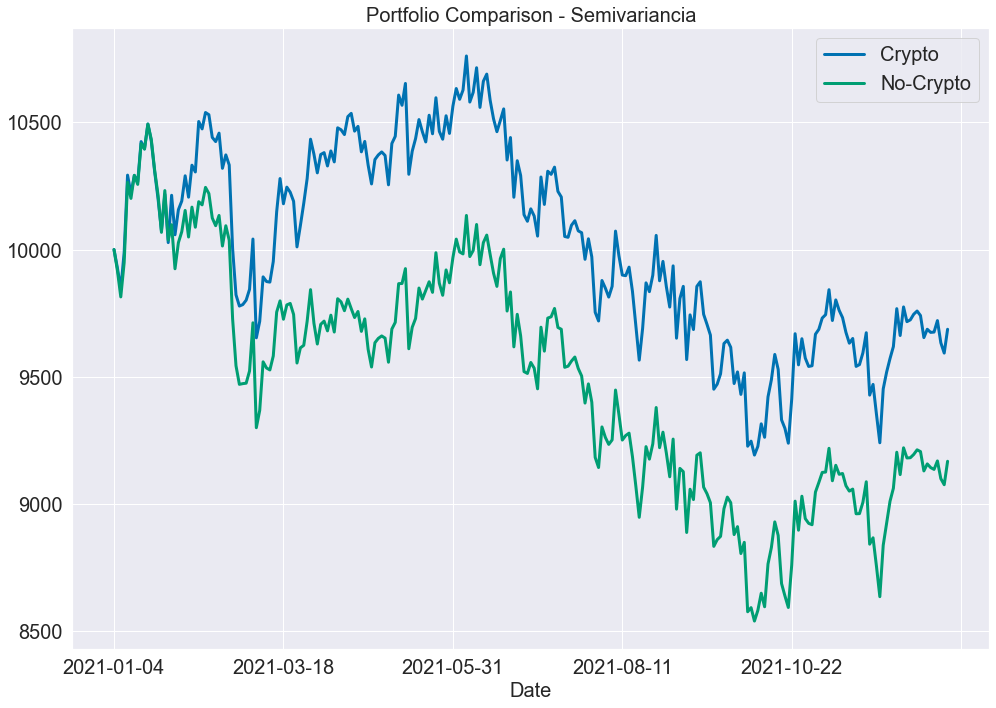

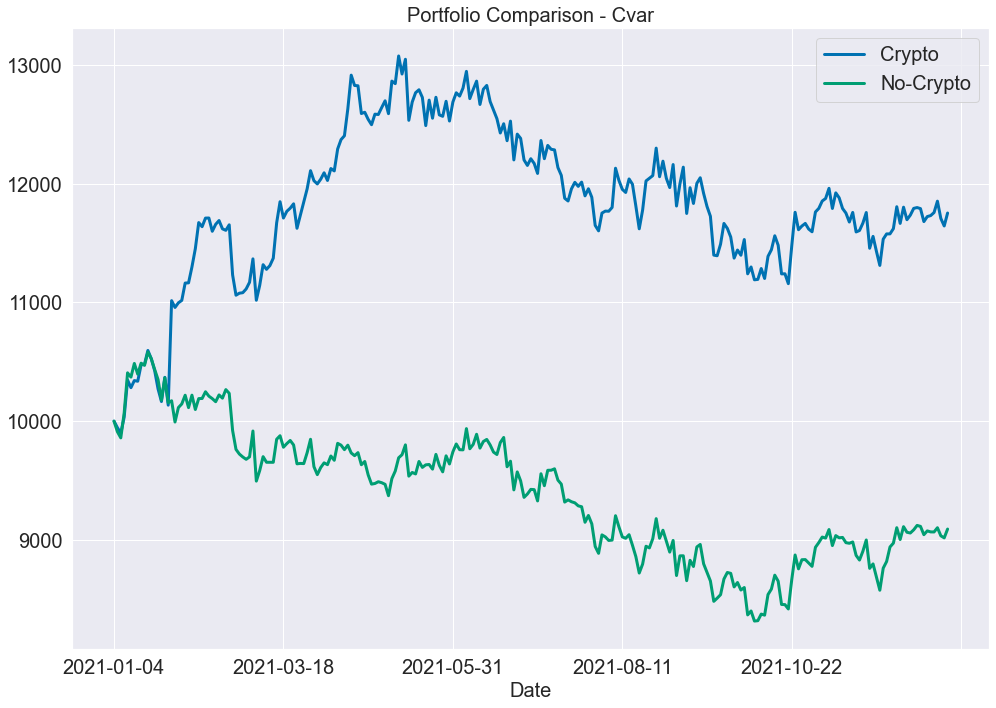

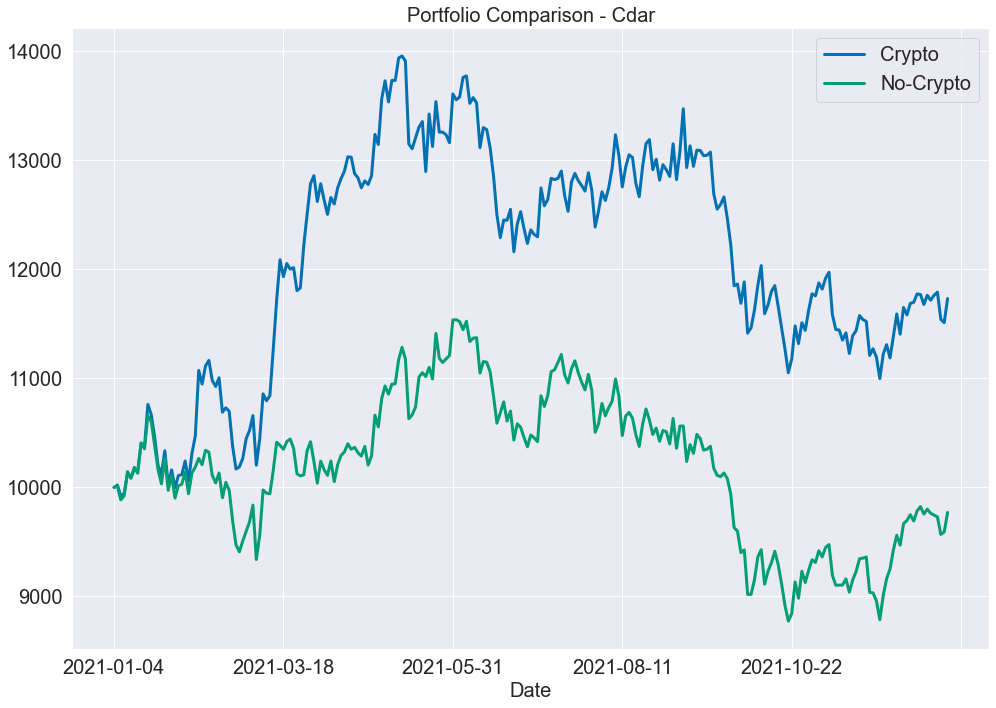

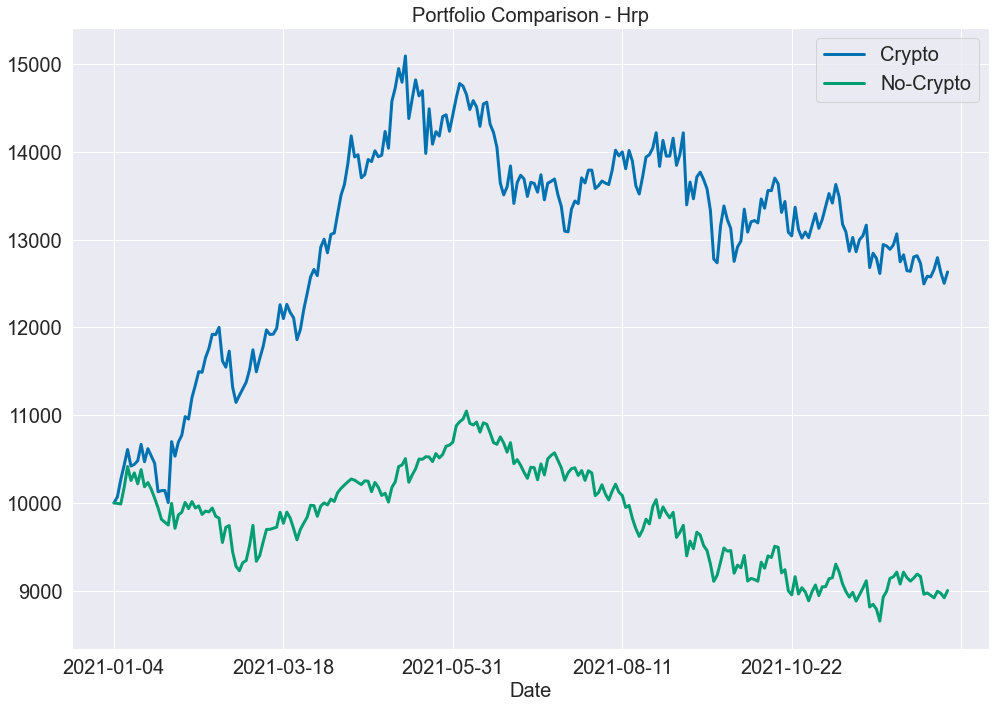

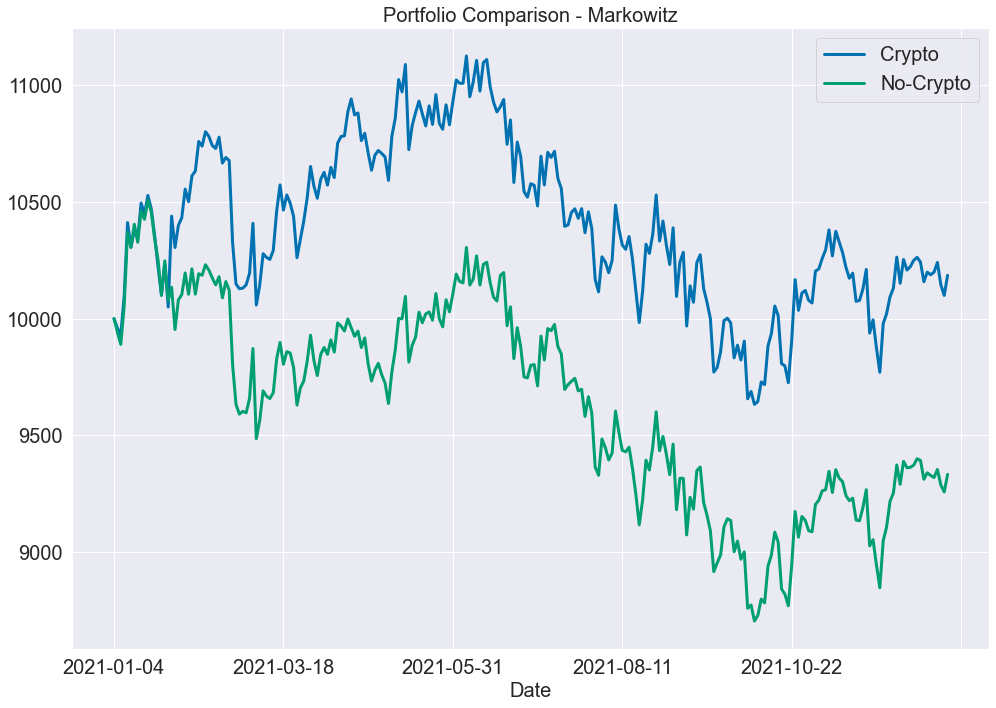

In [45]:
for tipo_port in tipos_port:
    compare_portfolios(tipo_port)